--------------------------------------------------[ p_h = 0.4 ]--------------------------------------------------


W0118 12:23:38.632583   82642 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0118 12:23:38.635396   82580 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


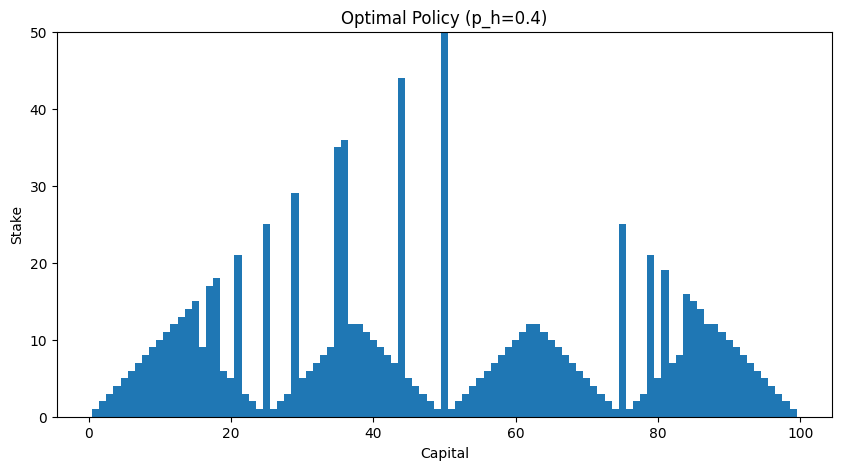

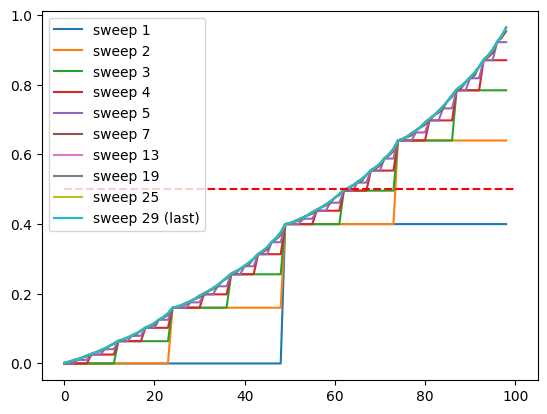

----------------------------------------------------------------------------------------------------
--------------------------------------------------[ p_h = 0.25 ]--------------------------------------------------


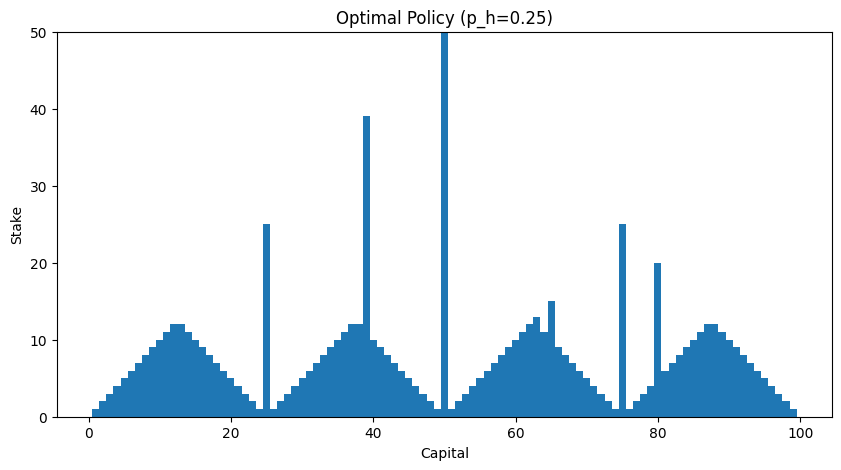

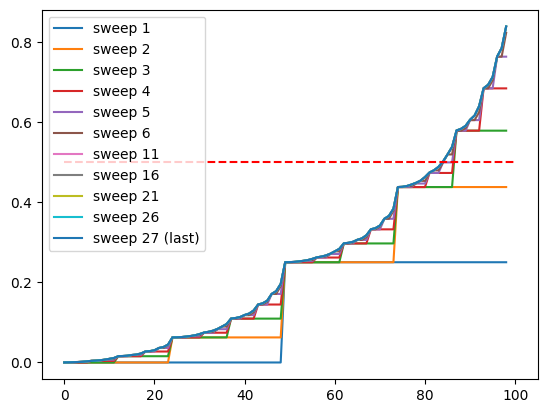

----------------------------------------------------------------------------------------------------
--------------------------------------------------[ p_h = 0.55 ]--------------------------------------------------


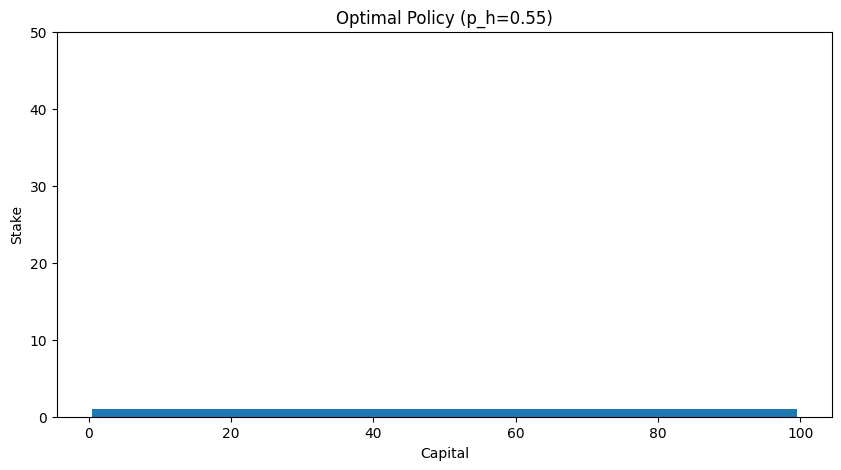

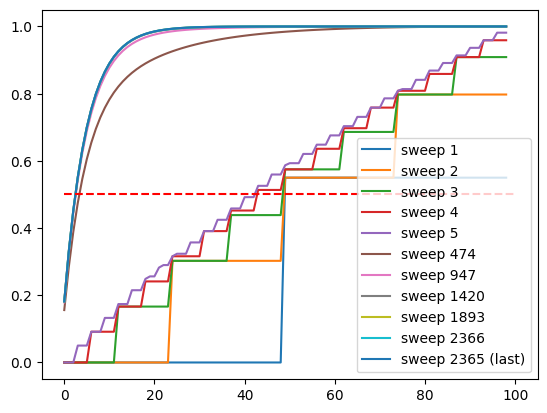

----------------------------------------------------------------------------------------------------


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# accuracy of estimation
THETA = 0.000000000001


# gamma = 1 since its episodic task
GAMMA = 1

def gamblers(p_h:float):
    print("-"*50 + f"[ p_h = {p_h} ]" + "-"*50)

    state_values = jnp.zeros((99), dtype=jnp.float32)

    possible_actions = jnp.arange(1, 51)

    valid_states = jnp.arange(1, 100)


    sweeps_history_values = []


    delta = THETA
    while delta >= THETA:

        max_stakes = jnp.minimum(valid_states, 100 - valid_states)
        actions = jnp.full((99, 50,), fill_value=possible_actions)
        actions = jnp.clip(actions, 0, jnp.expand_dims(max_stakes, 1))


        next_states_winning = jnp.expand_dims(valid_states, 1) + actions
        next_states_losing = jnp.expand_dims(valid_states, 1) - actions
        

        rewards = jnp.where(next_states_winning == 100, 1.0, 0.0)


        next_state_values_winning = jnp.where((0 < next_states_winning) & (next_states_winning < 100), state_values[next_states_winning - 1], 0)
        next_state_values_losing = jnp.where((0 < next_states_losing) & (next_states_losing < 100), state_values[next_states_losing - 1], 0)
        next_state_values = next_state_values_winning * p_h + next_state_values_losing * (1 - p_h)


        new_state_values_by_action = p_h * rewards + GAMMA * next_state_values


        new_state_values = jnp.max(new_state_values_by_action, 1)

        delta = jnp.max(jnp.abs(state_values - new_state_values))

        state_values = new_state_values
        sweeps_history_values.append(new_state_values)



    policy = jnp.argmax(new_state_values_by_action,1) + 1


    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(valid_states, policy, width=1.0) # Bar chart shows the discrete nature better
    # plt.plot(policy)
    plt.title(f"Optimal Policy (p_h={p_h})")
    plt.xlabel("Capital")
    plt.ylabel("Stake")
    plt.ylim(0,50)
    plt.show()

    i = 0
    for i, values in enumerate(sweeps_history_values):

        if i < 5 or i % (len(sweeps_history_values)//5) == 0:
            plt.plot(values, label=f"sweep {i+1}")

    plt.plot(state_values, label=f"sweep {i} (last)")
    plt.legend()
    plt.hlines(0.5, 0, 100, color="red", linestyles="--")
    plt.show()
    print("-"*100)


gamblers(0.4)
gamblers(0.25)
gamblers(0.55)